# Read input data set.

In [1]:
import pandas as pd
df = pd.read_csv('datasets/freesolv.csv')
df

,smiles,freesolv
0,CN(C)C(=O)c1ccc(cc1)OC,-11.01
1,CS(=O)(=O)Cl,-4.87
2,CC(C)C=C,1.83
3,CCc1cnccn1,-5.45
4,CCCCCCCO,-4.21
...,...,...
637,CCCCCCCC(=O)OC,-2.04
638,C1CCNC1,-5.48
639,c1cc(ccc1C=O)O,-8.83
640,CCCCCCCCl,0.29


In [2]:
from mgktools.data.data import Dataset
dataset = Dataset.from_df(
    df,
    pure_columns = ['smiles'],
    mixture_columns = None,
    reaction_columns = None,
    feature_columns = None,
    target_columns = ['freesolv'],
    features_generator = None,
    n_jobs = 1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 642 out of 642 | elapsed:    6.2s finished


In [3]:
# Save the dataset as dataset.pkl.
dataset.save(path='', filename='dataset.pkl', overwrite=True)

# Set marginalized graph kernel(MGK)

In [4]:
from mgktools.kernels.utils import get_kernel_config
kernel_config = get_kernel_config(
dataset,
graph_kernel_type = 'graph',
# arguments for vectorized features.
features_hyperparameters=None,
features_hyperparameters_bounds=None,
features_hyperparameters_file = None,
single_features_hyperparameter = False,
# arguments for marginalized graph kernel
mgk_hyperparameters_files = ['../hyperparameters/product-msnorm.json'],
# arguments for pre-computed kernel
kernel_dict = None,
kernel_pkl = 'kernel.pkl'
)
kernel = kernel_config.kernel
kernel

/home/xiangyan/apps/miniconda3/envs/test/lib/python3.8/site-packages/graphdot/codegen/sympy_printer.py:4: SymPyDeprecationWarning: 

The sympy.printing.cxxcode submodule is deprecated. It has been renamed to
sympy.printing.cxx.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-printing-code-submodules
for details.

This has been deprecated since SymPy version 1.7. It
will be removed in a future version of SymPy.

  from sympy.printing.cxxcode import CXX11CodePrinter


# Compute MGK matrix

In [5]:
dataset.graph_kernel_type = 'graph'
K = kernel(dataset.X)
K

array([[1.        , 0.02429088, 0.06919944, ..., 0.3976954 , 0.47657333,
        0.07443282],
       [0.02429088, 1.        , 0.23255556, ..., 0.14180597, 0.04156788,
        0.16690495],
       [0.06919944, 0.23255556, 1.        , ..., 0.29001227, 0.14865806,
        0.24395648],
       ...,
       [0.3976954 , 0.14180597, 0.29001227, ..., 1.        , 0.34119292,
        0.3991222 ],
       [0.47657333, 0.04156788, 0.14865806, ..., 0.34119292, 1.        ,
        0.11839457],
       [0.07443282, 0.16690495, 0.24395648, ..., 0.3991222 , 0.11839457,
        1.        ]])

# Gaussian process regression (GPR)

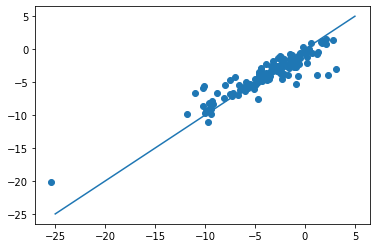

In [6]:
from mgktools.data import dataset_split
train, test = dataset_split(dataset, 
                            split_type='random',
                            sizes=[0.8, 0.2])
from mgktools.models.regression.GPRgraphdot.gpr import GPR
gpr = GPR(kernel=kernel,
          optimizer=None,
          alpha=0.01,
          normalize_y=True,
          batch_size=None)
gpr.fit(train.X, train.y)
y_pred = gpr.predict(test.X)
import matplotlib.pyplot as plt
plt.scatter(test.y, y_pred)
plt.plot([-25, 5], [-25, 5])